In [1]:
import numpy as np
from utils import make_dict, parse_file, get_matrices, write_predictions, write_metrics
import argparse
import logging

python forwardbackward.py toy_data/validation.txt toy_data/index_to_word.txt toy_data/index_to_tag.txt toy_data/hmminit.txt toy_data/hmmemit.txt toy_data/hmmtrans.txt toy_data/predicted.txt toy_data/metrics.txt

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('validation_input', type=str,help='path to validation input .txt file')
parser.add_argument('index_to_word', type=str,help='path to index_to_word.txt file')
parser.add_argument('index_to_tag', type=str,help='path to index_to_tag.txt file')
parser.add_argument('init', type=str,help='path to the learned hmm_init.txt (pi) file')
parser.add_argument('emission', type=str,help='path to the learned hmm_emission.txt (A) file')
parser.add_argument('transition', type=str,help='path to the learned hmm_transition.txt (B) file')
parser.add_argument('prediction_file', type=str,help='path to store predictions')
parser.add_argument('metric_file', type=str,help='path to store metrics')                    
parser.add_argument('--debug', type=bool, default=False,help='set to True to show logging')

In [ ]:
# parser.validation_input = "toy_data/validation.txt"
# parser.index_to_word = "toy_data/index_to_word.txt"
# parser.index_to_tag = "toy_data/index_to_tag.txt"
# parser.init = "toy_data/hmminit.txt"
# parser.emission = "toy_data/hmmemit.txt"
# parser.transition = "toy_data/hmmtrans.txt"
# parser.prediction_file = "toy_data/predicted.txt"
# parser.metric_file = "toy_data/metrics.txt"
# ## running main function outside need this
# args = parser

In [ ]:
parser.validation_input = "fr_data/validation.txt"
parser.index_to_word = "fr_data/index_to_word.txt"
parser.index_to_tag = "fr_data/index_to_tag.txt"
parser.init = "fr_data/hmminit.txt"
parser.emission = "fr_data/hmmemit.txt"
parser.transition = "fr_data/hmmtrans.txt"
parser.prediction_file = "fr_data/predicted.txt"
parser.metric_file = "fr_data/metrics.txt"
## running main function outside need this
args = parser

In [ ]:
word_dict = make_dict(args.index_to_word)
tag_dict = make_dict(args.index_to_tag)
init, emission, transition = get_matrices(args)
sentences, tags = parse_file(args.validation_input)

In [ ]:
# Hint: You might find it helpful to define functions 
# that do the following:
# 1. Calculate Alphas
# 2. Calculate Betas
# 3. Implement the LogSumExpTrick
# 4. Calculate probabilities and predictions

In [ ]:
## Alpha Without log

# sentence = sentences[0]
# alpha = np.empty((len(sentence),len(tag_dict)), dtype='float')
def cal_alpha(index):
    global alpha
    if index == 0:
        alpha[0] = init*emission[:,word_dict[sentence[index]]]
        return init*emission[:,word_dict[sentence[index]]]
    else: 
        alpha[index] = np.array(emission[:,word_dict[sentence[index]]])*transition.T.dot(cal_alpha(index-1))
#         (transition.T*np.tile(np.array(np.array(emission[:,word_dict[sentence[index]]]).reshape((emission.shape[0], 1))),(1,transition.T.shape[1]))).dot(cal_alpha(index-1))
        return alpha[index]
# cal_alpha(len(sentence)-1) ##one sentence only
# print(alpha)

In [2]:
def logSumExpTrick(v):
    m = []
    def logSumExpTrick1(v):
        m = max(v)
        return m + np.log(sum(np.exp(v-m)))
    for v_r in v:
        m.append(logSumExpTrick1(v_r))
#     m = v.max(1)
#     return m + np.log((np.exp(v-m.T)).sum(axis=1))
    return m

In [3]:
## With log
def get_alpha_l(sentence,tag_dict,init,emission,transition,word_dict):
    alpha_l = np.empty((len(sentence),len(tag_dict)), dtype='float')
    def cal_alpha_l(index):
        nonlocal alpha_l
        if index == 0:
            alpha_l[0] = np.log(init)+np.log(emission[:,word_dict[sentence[index]]])
            return alpha_l[0]
        else: 
            al = np.log(emission[:,word_dict[sentence[index]]])+logSumExpTrick(np.log(transition.T)+cal_alpha_l(index-1))
            alpha_l[index] = al.copy()
            return al
    cal_alpha_l(len(sentence)-1) ##one sentence only
    return alpha_l
# alpha_l = get_alpha_l(sentences[0],tag_dict)

In [ ]:
## Beta Without log

# sentence = sentences[0]
# beta = np.empty((len(sentence),len(tag_dict)), dtype='float')
def cal_beta(index,length):
    global beta
    if index == length-1:
        beta[index] = np.ones((1,len(tag_dict)))
        return np.array([1,1]).T
    else:
        W_jkt = transition*np.tile(np.array(np.array(emission[:,word_dict[sentence[index+1]]]).reshape((emission.shape[0], 1))),(1,transition.T.shape[1])).T
        beta[index] = W_jkt.dot(cal_beta(index+1,length))
        return beta[index]
# cal_beta(0,len(sentence)) ##one sentence only
# print(beta)

In [4]:
## Beta with log
def get_beta_l(sentence, tag_dict,emission,transition,word_dict):
    beta_l = np.empty((len(sentence),len(tag_dict)), dtype='float')
    def cal_beta_l(index,length):
        nonlocal beta_l
        if index == length-1:
            beta_l[index] = np.zeros((1,len(tag_dict)))
            return beta_l[index].copy()
        else:
            beta_l[index]  = logSumExpTrick(np.log(transition)+np.log(emission[:,word_dict[sentence[index+1]]])+cal_beta_l(index+1,length))
            return beta_l[index]
    cal_beta_l(0,len(sentence)) ##one sentence only
    return beta_l
# beta_l = get_beta_l(sentences[0],tag_dict)

In [5]:
def predict(p_yt_l,tag_dict):
    p_yt = np.exp(p_yt_l)
    result = []
    for i in p_yt:
        max_index = np.argmax(i)
        result.append(list(tag_dict.keys())[list(tag_dict.values()).index(max_index)])
    return result
# predict(p_yt_l)

In [6]:
def logSumExpTrick_llh(v):
        m = v.max()
        return m + np.log(sum(np.exp(v-m)))

In [7]:
def avg_loglikelihood(alpha_l):
    return logSumExpTrick_llh(alpha_l[-1])

In [10]:
parser = argparse.ArgumentParser()
parser.add_argument('validation_input', type=str,help='path to validation input .txt file')
parser.add_argument('index_to_word', type=str,help='path to index_to_word.txt file')
parser.add_argument('index_to_tag', type=str,help='path to index_to_tag.txt file')
parser.add_argument('init', type=str,help='path to the learned hmm_init.txt (pi) file')
parser.add_argument('emission', type=str,help='path to the learned hmm_emission.txt (A) file')
parser.add_argument('transition', type=str,help='path to the learned hmm_transition.txt (B) file')
parser.add_argument('prediction_file', type=str,help='path to store predictions')
parser.add_argument('metric_file', type=str,help='path to store metrics')                    
parser.add_argument('--debug', type=bool, default=False,help='set to True to show logging')
parser.index_to_word = "en_data/index_to_word.txt"
parser.index_to_tag = "en_data/index_to_tag.txt"
## running main function outside need this

x = [10,100,1000,10000]
overall = []
for data in ["en_data/train.txt","en_data/validation.txt"]:
    parser.validation_input = data
    result = []
    for i in x:
        parser.init = "en_data/hmminit"+"_"+str(i)+".txt"
        parser.emission = "en_data/hmmemit"+"_"+str(i)+".txt"
        parser.transition = "en_data/hmmtrans"+"_"+str(i)+".txt"
        args = parser
        word_dict = make_dict(args.index_to_word)
        tag_dict = make_dict(args.index_to_tag)
        # Parse the validation file
        sentences, tags = parse_file(args.validation_input)
        ## Load your learned matrices
        ## Make sure you have them in the right orientation
        init, emission, transition = get_matrices(args)
        predictions = []
        log_likelihoods = []
        for sentence in sentences:
            alpha_l = get_alpha_l(sentence,tag_dict,init,emission,transition,word_dict) 
            beta_l = get_beta_l(sentence,tag_dict,emission,transition,word_dict)
            p_yt_l = alpha_l+beta_l
            predictions.append(predict(p_yt_l,tag_dict))
            log_likelihoods.append(avg_loglikelihood(alpha_l))
        predicted_tags = predictions #TODO: store your predicted tags here (in the right order)
        avg_log_likelihood = sum(log_likelihoods)/len(sentences)# TODO: store your calculated average log-likelihood here
        result.append(avg_log_likelihood)
    overall.append(result)

In [11]:
overall

[[-80.54472148949841,
  -74.99444935893663,
  -67.59317395746378,
  -60.61228444225903],
 [-87.97153090660595,
  -80.83229271827628,
  -70.45566558750289,
  -61.08562092334479]]

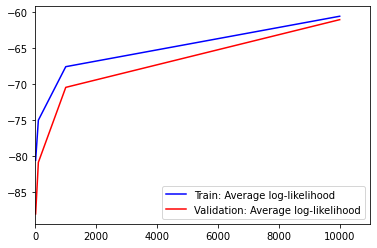

In [14]:
import matplotlib.pyplot as plt
plt.plot(x, overall[0],'b',label="Train: Average log-likelihood")
plt.plot(x, overall[1],'r',label="Validation: Average log-likelihood")
# plt.ylim(0, 0.6)
plt.xlim(0,11000)
plt.legend(loc="lower right")
plt.savefig('5_2.png')
plt.show()

In [ ]:
def main(args):
    # Get the dictionaries
    word_dict = make_dict(args.index_to_word)
    tag_dict = make_dict(args.index_to_tag)
    # Parse the validation file
    sentences, tags = parse_file(args.validation_input)
    ## Load your learned matrices
    ## Make sure you have them in the right orientation
    init, emission, transition = get_matrices(args)
    predictions = []
    log_likelihoods = []
    for sentence in sentences:
        alpha_l = get_alpha_l(sentence,tag_dict,init,emission,transition,word_dict) 
        beta_l = get_beta_l(sentence,tag_dict,emission,transition,word_dict)
        p_yt_l = alpha_l+beta_l
        predictions.append(predict(p_yt_l,tag_dict))
        log_likelihoods.append(avg_loglikelihood(alpha_l))

    predicted_tags = predictions #TODO: store your predicted tags here (in the right order)
    avg_log_likelihood = sum(log_likelihoods)/len(sentences)# TODO: store your calculated average log-likelihood here
    
    accuracy = 0 # We'll calculate this for you

    ## Writing results to the corresponding files.  
    accuracy = write_predictions(args.prediction_file, sentences, predicted_tags, tags)
    write_metrics(args.metric_file, avg_log_likelihood, accuracy)

    return